# Outliers detection using AutoEncoders

In [1]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.model_selection import KFold


Using TensorFlow backend.


## Data loading

In [2]:
%run ../util/load_data.py
%run ../util/data_visualization.py

data = load_data("../data")

train_data_with_outliers = data['train_data'][data['numerical_attributes'] + ['Id']]

/Users/andrluc/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/andrluc/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


## Outliers detection with Auto-Encoders

### Network construction

In [3]:
nb_epoch = 10
batch_size = 128
input_dim = len(data['numerical_attributes']) #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-5

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)



### Outliers detection

In [4]:
kf = KFold(n_splits=10)

outliers_ids = []

for train, test in kf.split(train_data_with_outliers):
    train_data = train_data_with_outliers.iloc[train, :]
    test_data = train_data_with_outliers.iloc[test, :]
    
    
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
    
    autoencoder.fit(train_data.drop("Id", axis=1), train_data.drop("Id", axis=1),
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1)
    
    test_data_predictions = autoencoder.predict(test_data.drop("Id", axis=1))
    
    mse = np.mean(np.power(test_data.drop("Id", axis=1) - test_data_predictions, 2), axis=1)
    mse_mean = np.mean(mse)
    
    prediction_result = zip(
        train_data_with_outliers['Id'].values,
        mse
    )
    
    outliers_ids += [id for id, distance in prediction_result if distance > mse_mean * 1.5]
    
    
    

Epoch 1/10
13608/13608 [==============================] - 1s 50us/step - loss: 1442528.4409 - acc: 0.5436
Epoch 2/10
13608/13608 [==============================] - 0s 19us/step - loss: 1440820.2930 - acc: 0.8712
Epoch 3/10
13608/13608 [==============================] - 0s 31us/step - loss: 1439425.7290 - acc: 0.8712: 0s - loss: 1457007.4621 - acc:
Epoch 4/10
13608/13608 [==============================] - 0s 28us/step - loss: 1438181.4702 - acc: 0.8712
Epoch 5/10
13608/13608 [==============================] - 0s 23us/step - loss: 1436995.0811 - acc: 0.8712
Epoch 6/10
13608/13608 [==============================] - 0s 24us/step - loss: 1435838.5667 - acc: 0.8712
Epoch 7/10
13608/13608 [==============================] - 0s 21us/step - loss: 1434700.3921 - acc: 0.8712
Epoch 8/10
13608/13608 [==============================] - 0s 24us/step - loss: 1433575.6616 - acc: 0.8712
Epoch 9/10
13608/13608 [==============================] - 0s 23us/step - loss: 1432459.2914 - acc: 0.8712
Epoch 10/10
13

13608/13608 [==============================] - 0s 27us/step - loss: 1503347.8679 - acc: 0.8326
Epoch 8/10
13608/13608 [==============================] - 0s 22us/step - loss: 1502292.5619 - acc: 0.8326
Epoch 9/10
13608/13608 [==============================] - 0s 21us/step - loss: 1501239.1048 - acc: 0.8326
Epoch 10/10
13608/13608 [==============================] - 0s 19us/step - loss: 1500186.3364 - acc: 0.8326
Epoch 1/10
13608/13608 [==============================] - 1s 59us/step - loss: 1600465.9108 - acc: 0.8029
Epoch 2/10
13608/13608 [==============================] - 0s 22us/step - loss: 1599375.0151 - acc: 0.8029
Epoch 3/10
13608/13608 [==============================] - 0s 19us/step - loss: 1598286.6274 - acc: 0.8029
Epoch 4/10
13608/13608 [==============================] - 0s 19us/step - loss: 1597199.5321 - acc: 0.8029
Epoch 5/10
13608/13608 [==============================] - 0s 20us/step - loss: 1596113.7582 - acc: 0.8029
Epoch 6/10
13608/13608 [==============================] 

### Outlier removal

In [5]:
train_data = data['train_data']

data_without_auto_encoders_outliers = train_data[~train_data['Id'].isin(outliers_ids)]
data_without_auto_encoders_outliers.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Type
32,33,2519,102,6,124,4,616,230,233,137,5559,5,8,1
37,38,2511,92,7,182,18,722,231,229,131,5494,5,8,1
47,48,2536,99,6,234,0,659,230,232,136,5475,5,8,1
69,70,2640,80,8,180,-2,1092,231,225,127,5866,2,9,1
84,85,2537,42,7,210,17,1132,222,224,137,4919,2,8,1


# Visualization

### PCA Visualization

#### Old data

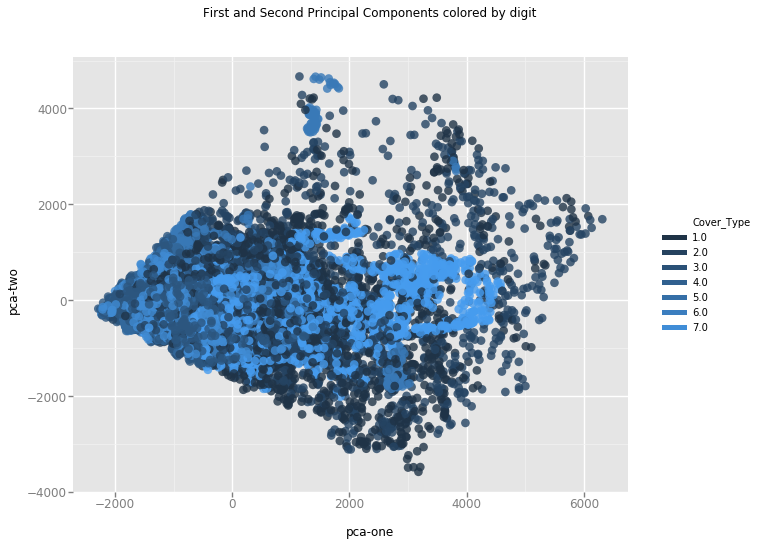

<ggplot: (-9223372036571957991)>

In [6]:
pca_visualization(data['train_data'][data['numerical_attributes'] + data['target']], data['target'][0])

#### Data without outliers

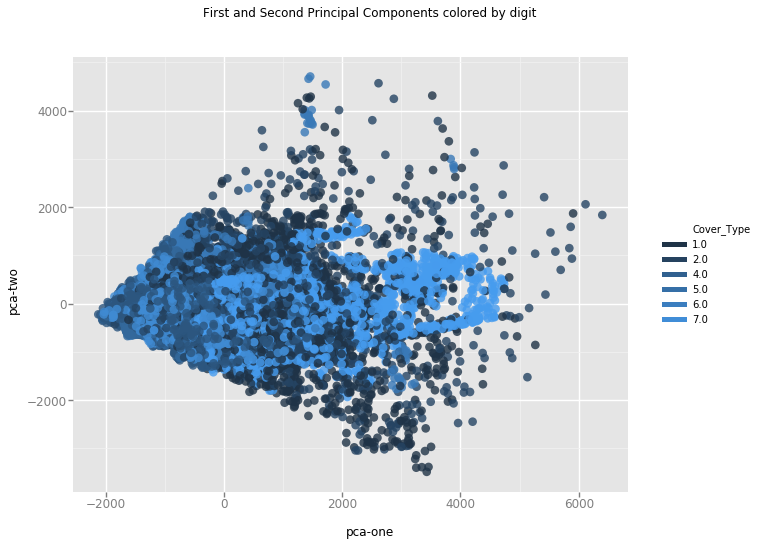

<ggplot: (303290183)>

In [7]:
pca_visualization(data_without_auto_encoders_outliers[data['numerical_attributes'] + data['target']], data['target'][0])

### TSNE

##### Old data

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15120 samples in 0.011s...
[t-SNE] Computed neighbors for 15120 samples in 0.934s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15120
[t-SNE] Computed conditional probabilities for sample 2000 / 15120
[t-SNE] Computed conditional probabilities for sample 3000 / 15120
[t-SNE] Computed conditional probabilities for sample 4000 / 15120
[t-SNE] Computed conditional probabilities for sample 5000 / 15120
[t-SNE] Computed conditional probabilities for sample 6000 / 15120
[t-SNE] Computed conditional probabilities for sample 7000 / 15120
[t-SNE] Computed conditional probabilities for sample 8000 / 15120
[t-SNE] Computed conditional probabilities for sample 9000 / 15120
[t-SNE] Computed conditional probabilities for sample 10000 / 15120
[t-SNE] Computed conditional probabilities for sample 11000 / 15120
[t-SNE] Computed conditional probabilities for sample 12000 / 15120
[t-SNE] Computed conditional probabilities for sa

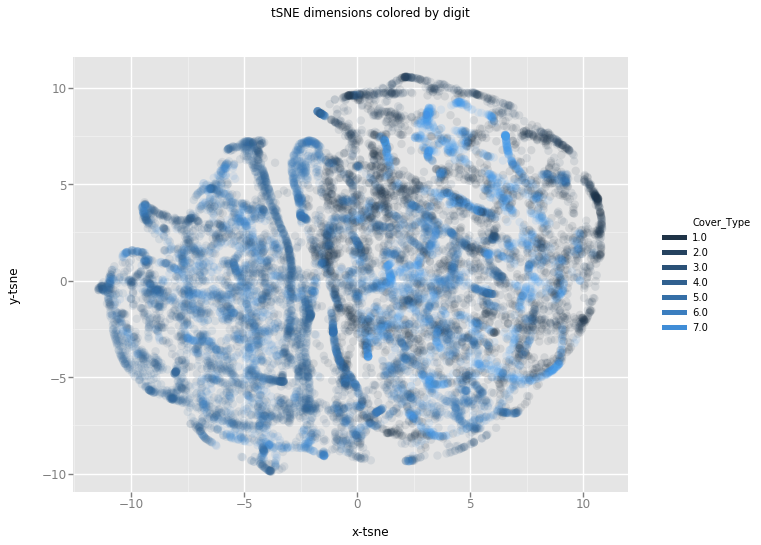

<ggplot: (303290260)>

In [8]:
tsne_visualization(data['train_data'][data['numerical_attributes'] + data['target']], data['target'][0])

##### Data without outliers

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13916 samples in 0.012s...
[t-SNE] Computed neighbors for 13916 samples in 1.020s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13916
[t-SNE] Computed conditional probabilities for sample 2000 / 13916
[t-SNE] Computed conditional probabilities for sample 3000 / 13916
[t-SNE] Computed conditional probabilities for sample 4000 / 13916
[t-SNE] Computed conditional probabilities for sample 5000 / 13916
[t-SNE] Computed conditional probabilities for sample 6000 / 13916
[t-SNE] Computed conditional probabilities for sample 7000 / 13916
[t-SNE] Computed conditional probabilities for sample 8000 / 13916
[t-SNE] Computed conditional probabilities for sample 9000 / 13916
[t-SNE] Computed conditional probabilities for sample 10000 / 13916
[t-SNE] Computed conditional probabilities for sample 11000 / 13916
[t-SNE] Computed conditional probabilities for sample 12000 / 13916
[t-SNE] Computed conditional probabilities for sa

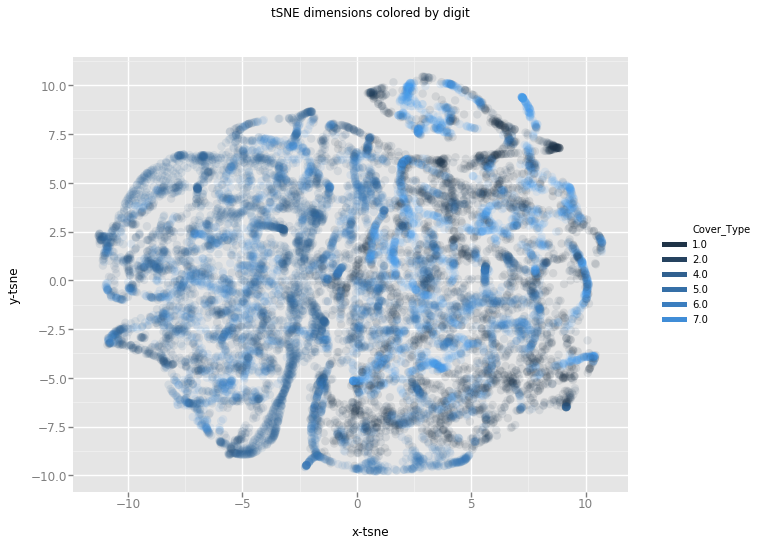

<ggplot: (303610095)>

In [9]:
tsne_visualization(data_without_auto_encoders_outliers[data['numerical_attributes'] + data['target']], data['target'][0])

### UMAP

##### Old data

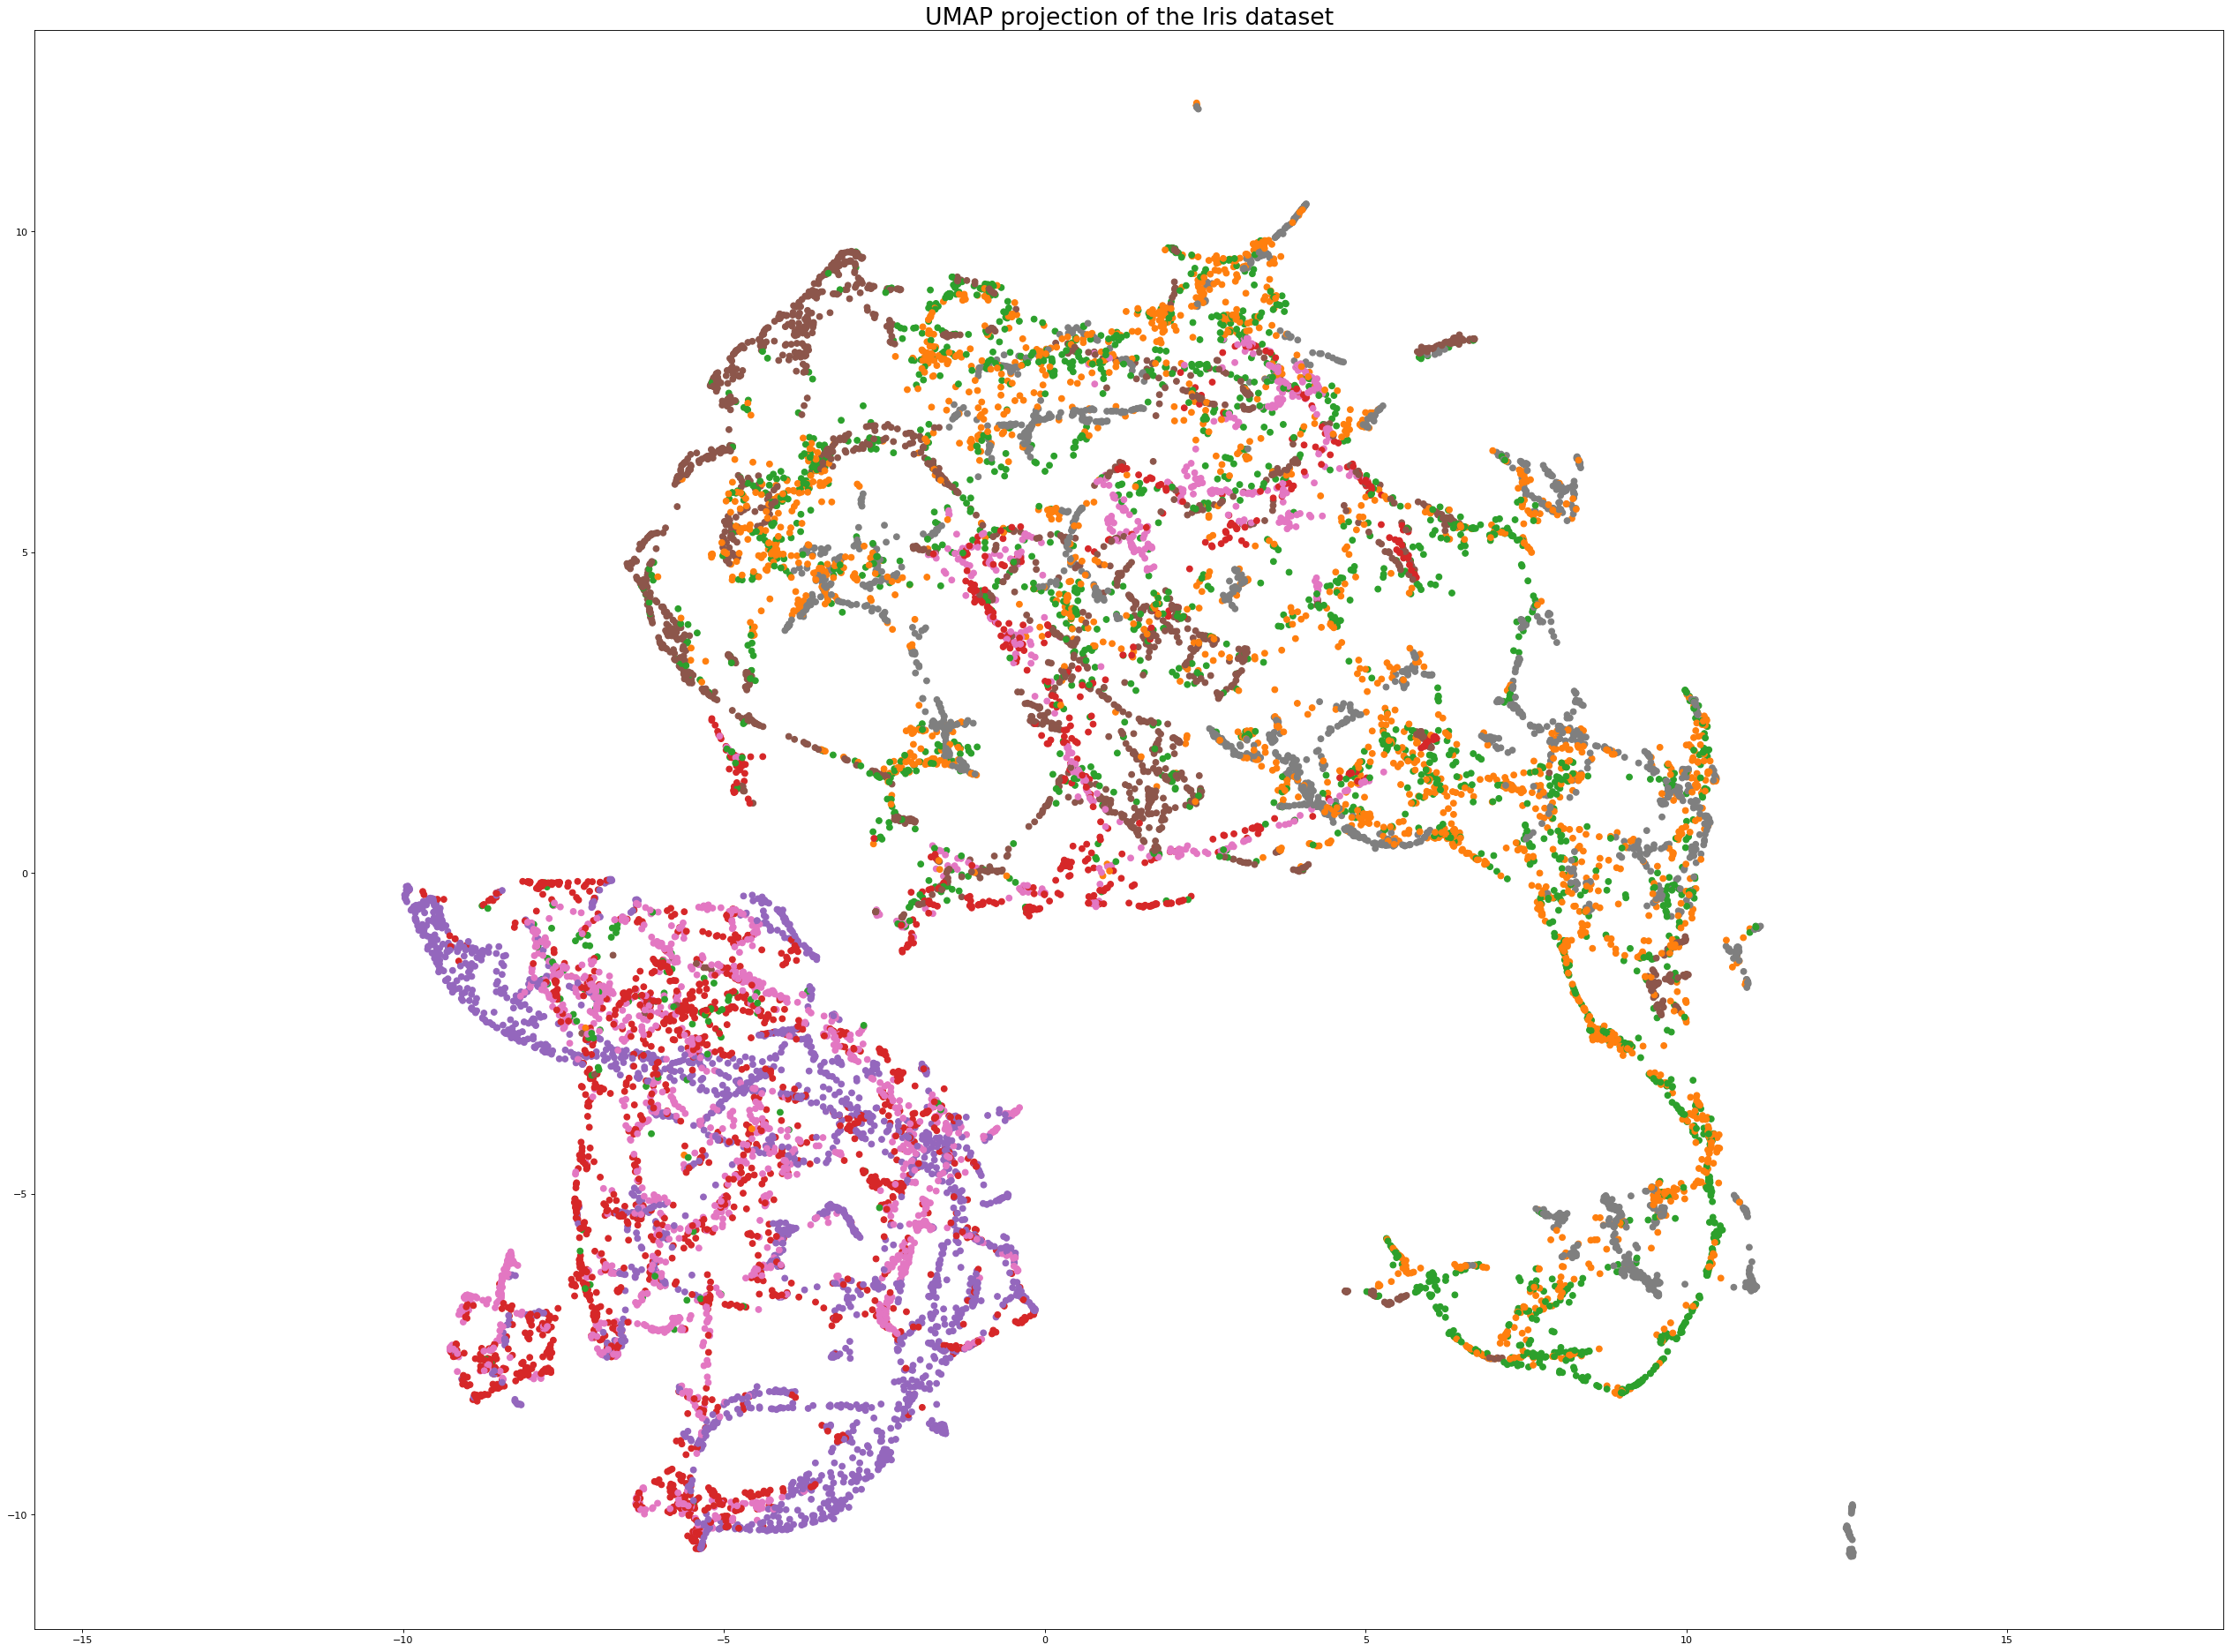

In [10]:
umap_visualization(data['train_data'][data['numerical_attributes'] + data['target']], data['target'][0])

##### Data without outliers

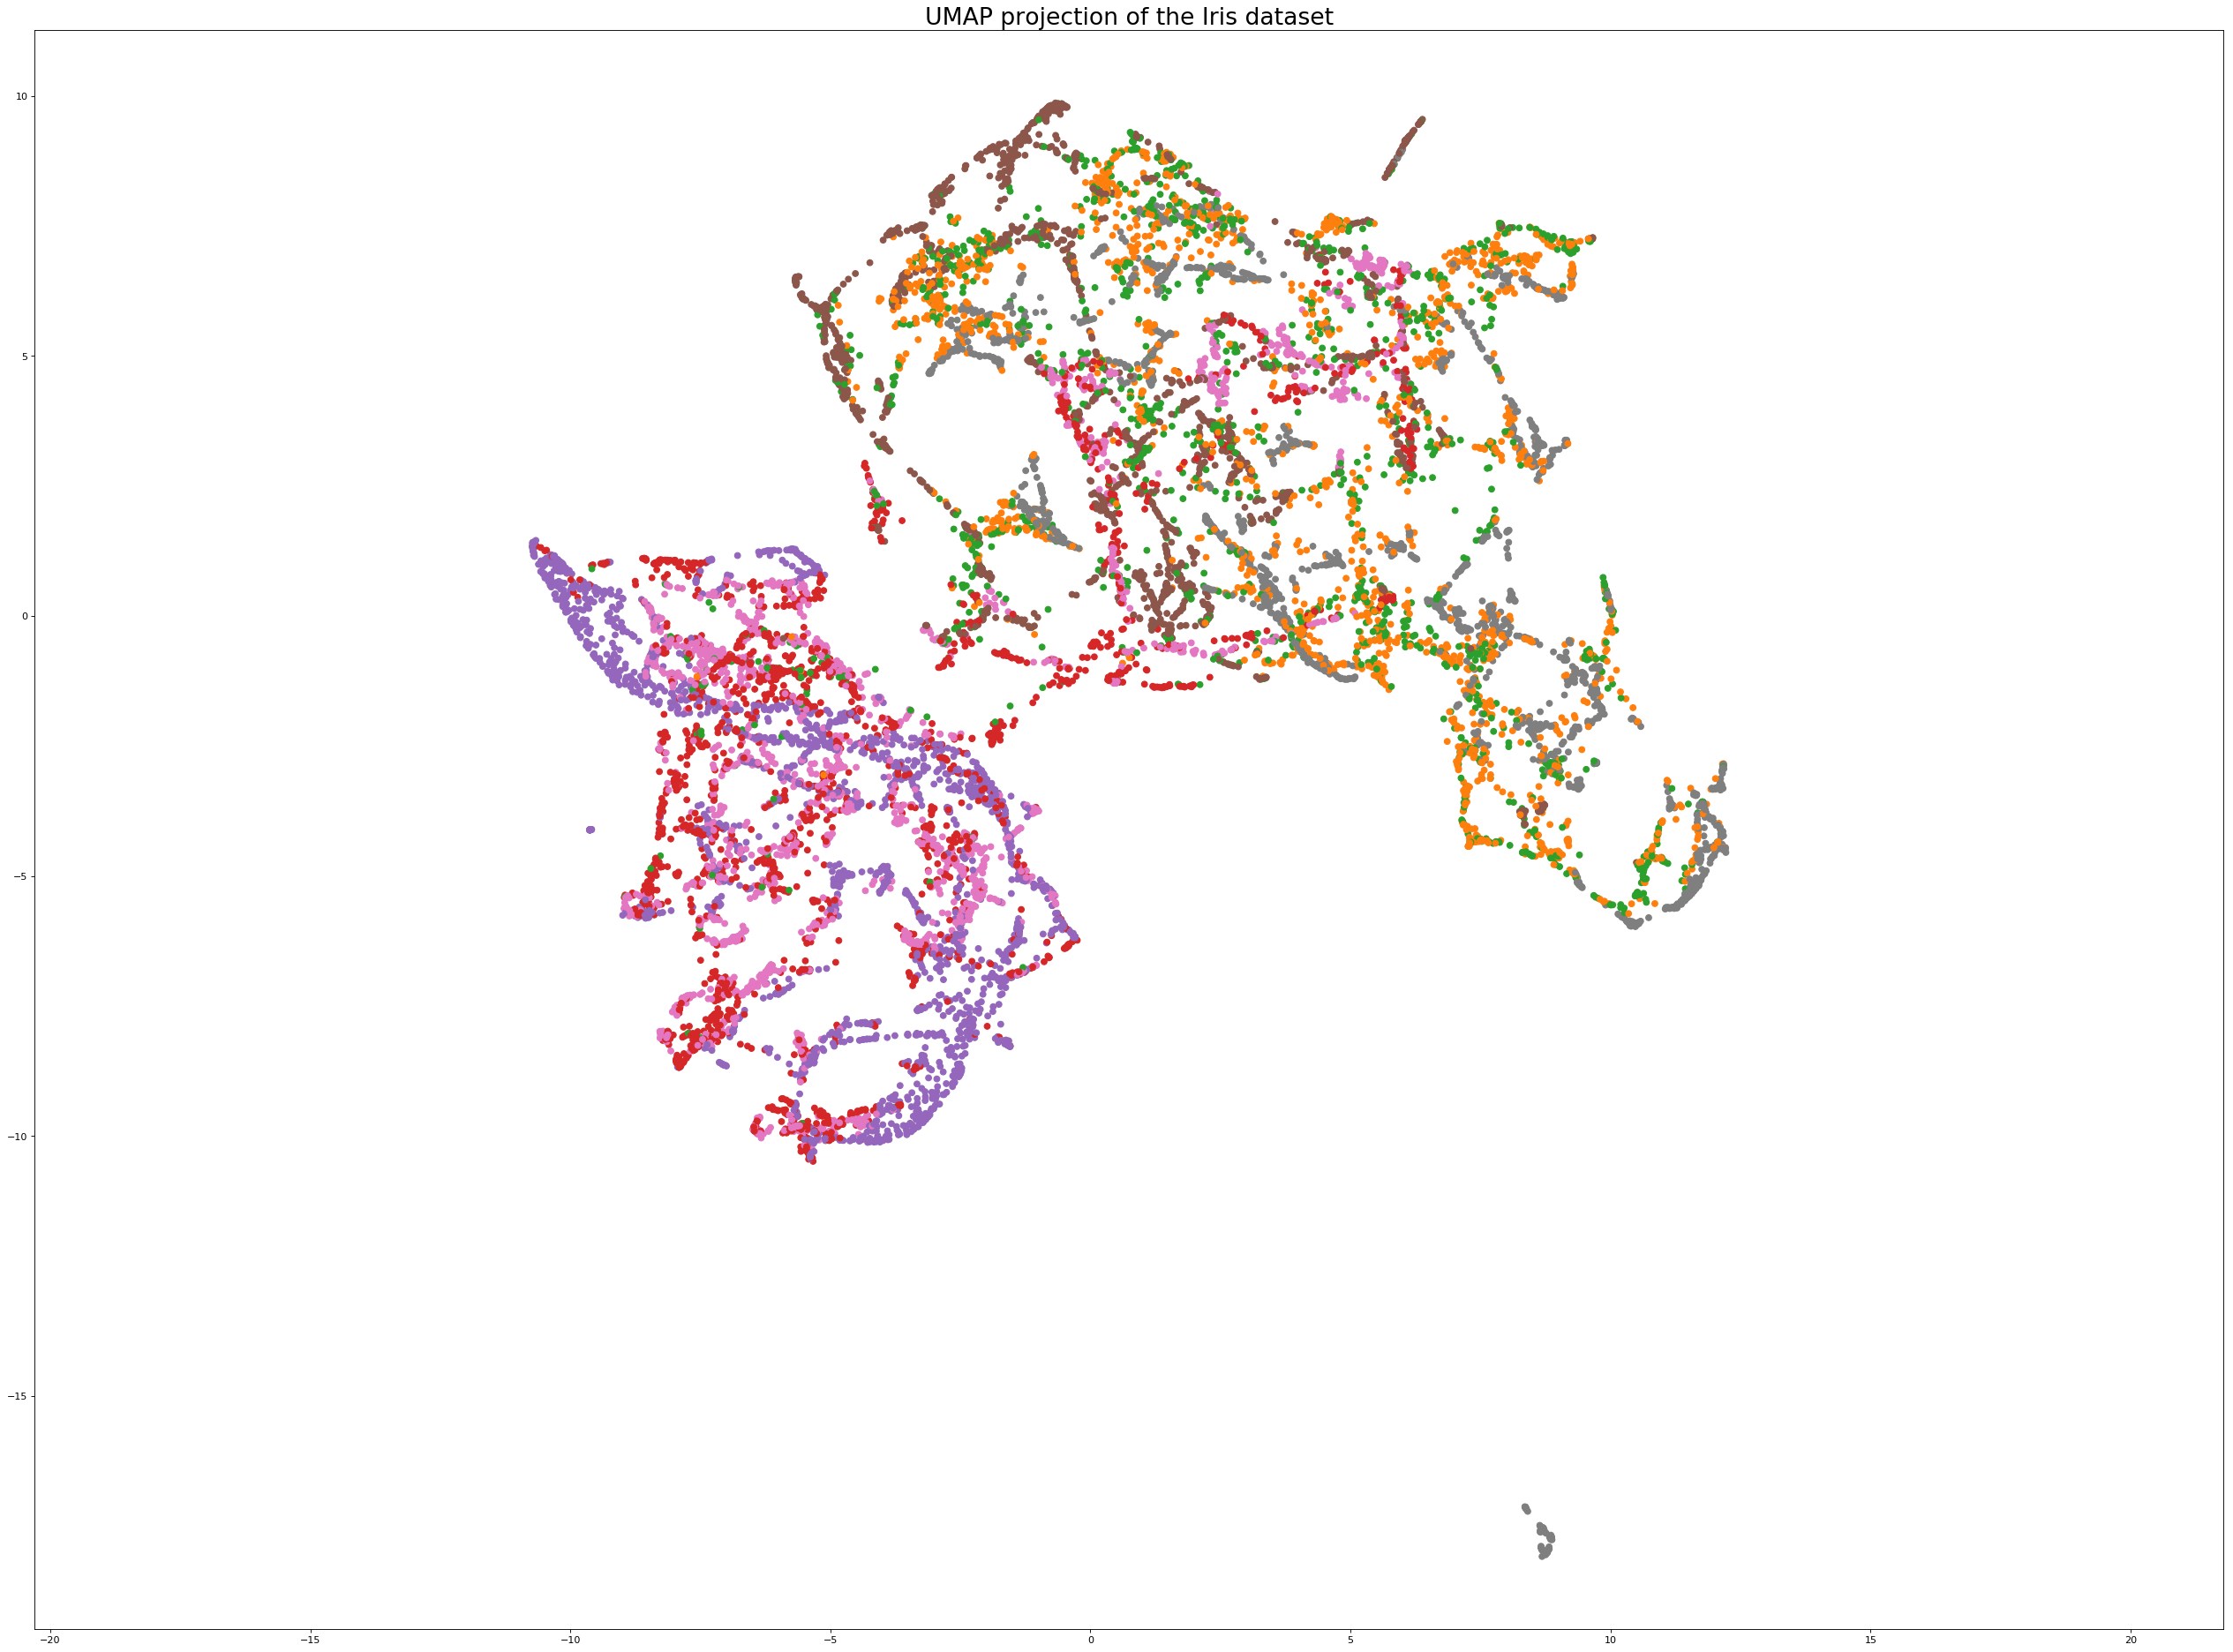

In [11]:
umap_visualization(data_without_auto_encoders_outliers[data['numerical_attributes'] + data['target']], data['target'][0])